# German Credit Dataset - Project 3
> Name: Sharun Garg  
Student ID: 200493338

## Importing important libraries and packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
from mpl_toolkits.mplot3d import Axes3D 
import warnings
warnings.filterwarnings("ignore")

# Reading the excel file of data as Pandas Dataframe

In [2]:
file = "german_credit_data.xlsx"
data = pd.read_excel(file)

# Printing a sample of random rows from the dataframe

In [3]:
data.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
802,24,female,2,own,little,little,4272,20,furniture/equipment,good
722,24,female,1,own,little,little,1228,12,car,bad
798,54,male,2,own,NaN,NaN,717,24,car,good
474,33,male,2,own,little,moderate,1245,18,radio/TV,bad
746,23,female,2,rent,little,little,2511,15,car,good
808,55,male,3,free,little,moderate,9283,42,car,good
334,23,male,2,rent,little,little,4110,24,furniture/equipment,bad
33,57,male,1,rent,NaN,NaN,1264,12,business,good
444,30,female,3,own,little,moderate,5096,48,furniture/equipment,bad
869,24,female,2,rent,little,little,652,12,furniture/equipment,good


### Explanation of the columns in dataset

> - **Age** (Numerical) - Customer's age.
> - **Sex** (Categorical) - Customer's sex, Male or Female.  
> - **Job** (Numerical) - Job of the customer, 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly
skilled)
> - **Housing** (Categorical) - Type of housing customer lives in, 'own', 'rent' or 'free'.
> - **Saving accounts** (Categorical) - balance of savigs account of customer, 'little', 'moderate', 'quite rich' or 'rich'.
> - **Checking account** (Categoricl) - balance of checking account of customer, 'little', 'moderate', or 'rich'..
> - **Credit amount** (Numerical) - Credit amount in Deutsch Mark.
> - **Duration** (Numerical) - duration of credit in months.
> - **Purpose** (Categorical) - purpose of credit, 'car', 'furniture/equipment', 'radio/TV', 'domestic appliances', 'repairs', 'education', 'business', 'vacation/others'.  
> - **Risk** (Categorical) - lable marking the data entry as 'good' or 'bad' credit.

# EDA and Data Wrangling

### Getting the info on dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


> As we can see there are missing values for 'Savings Accounts' and 'Checking Accounts' variables. Also we have catergorical variables in object form, which we'll be encoding to numerical values later.

### Checking for the number of categories in Saving Accounts variable

In [5]:
data["Saving accounts"].value_counts()

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

### Checking for the number of categories in Checking Accounts variable

In [6]:
data["Checking account"].value_counts()

little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

### Checking for the number of good/bad risks

In [7]:
data["Risk"].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

> 70% of applicants have a low risk

### Checking for number of missing values

In [8]:
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

> The null values of savings and checking account are handled later.

### Heatmap between the data variables

<AxesSubplot:>

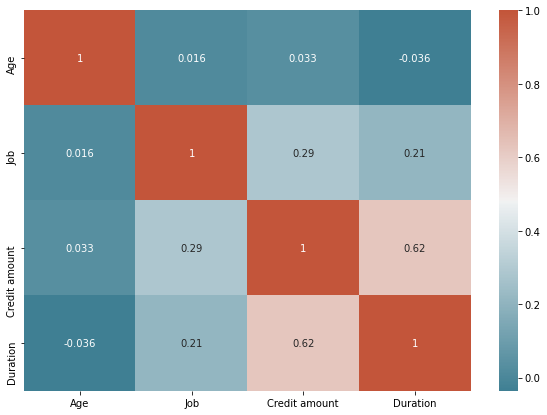

In [9]:
corr = data.corr()
plt.subplots(figsize=(10,7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

> **Observation:**  
We can see that there's no strong relation between any of the numerical variables which is a good thing. The 'credit amount' and 'duration' has a moderate corelation of 0.62 which is understandable as high amount credits are usually for a longer period.

## Plotting the number of values for the categorical variables.

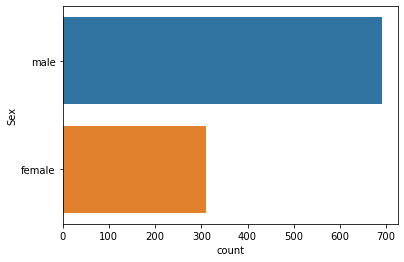

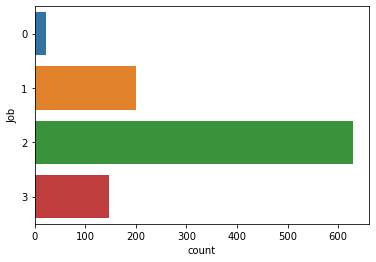

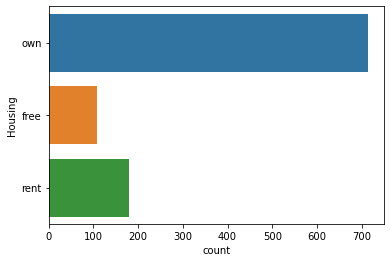

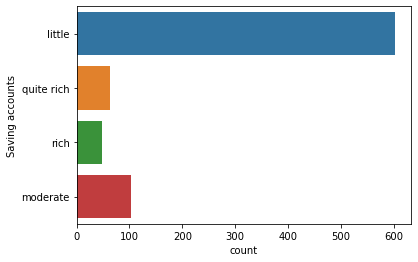

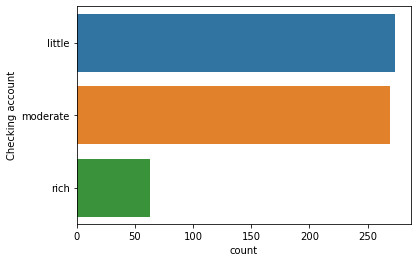

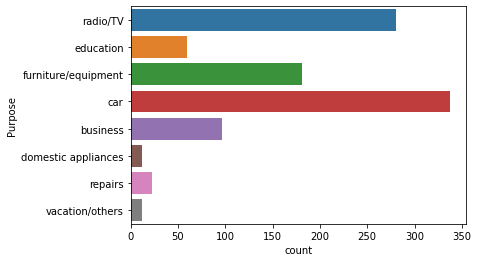

In [10]:
cat_cols = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']
for col in cat_cols:
    sns.countplot(y =col, data = data)
    plt.show()

> We can observe that 70% percent of the data avialable if of male applicants. 60% of the applicants have a skilled job. 70% of the applicants have their own house and about 60% of the applicants have a significantly low balance in saving accounts.

## Evaluating Risks for categorical variables.

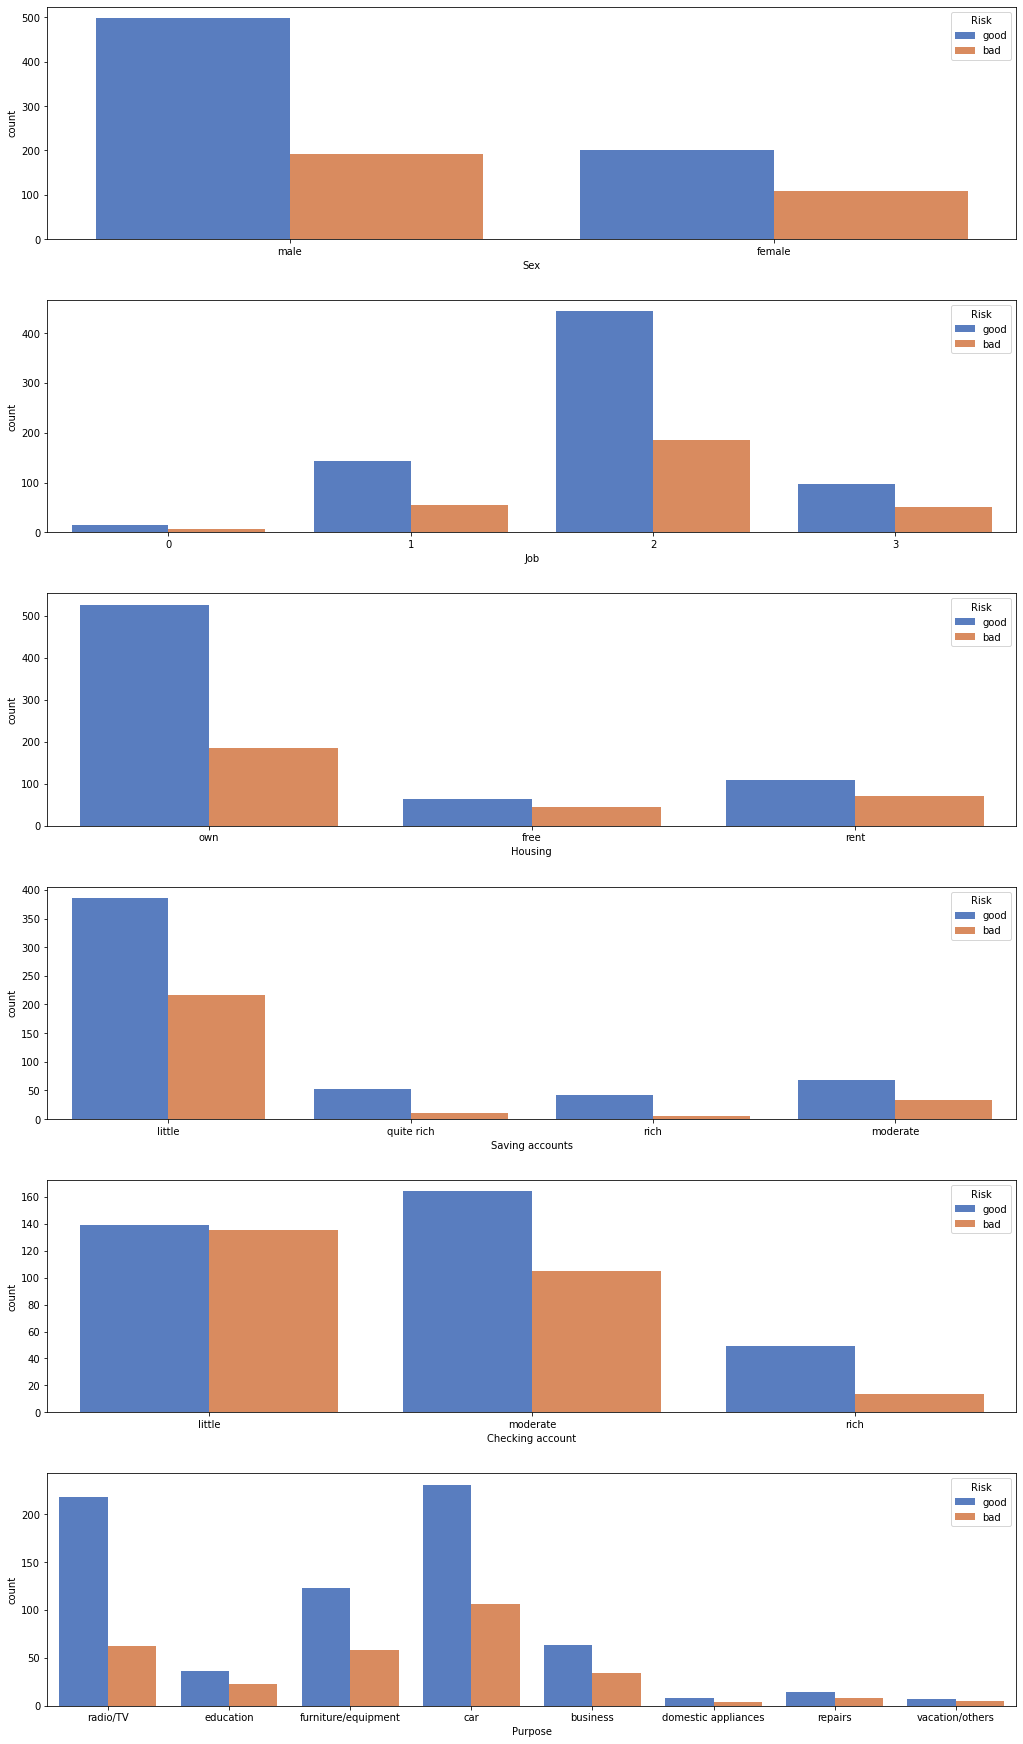

In [11]:
fig, ax = plt.subplots(len(cat_cols),1,figsize=(15,25))
plt.tight_layout(4)
i = 0
for col in cat_cols:
    sns.countplot(data[col], hue=data.Risk, ax = ax[i], palette='muted')
    i+=1

> **Observation:**  
It can be observed that there's not any good/bad risk associated with a particular category and data seems to be spread equally for all the categories. As we have 70% of good risks in data set, it is visible from plot that the good risks are more than bad risks with somewhat uniform ratio.

## Checking for Skewness in numerical variables

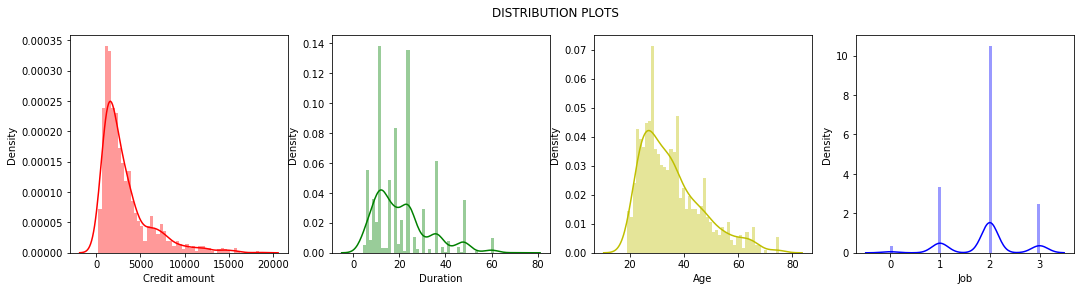

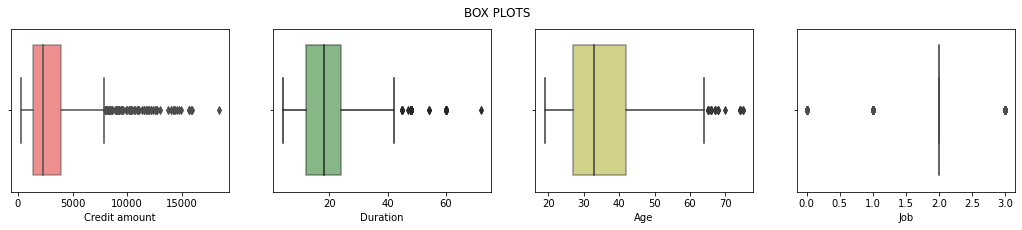

In [12]:
fig, ax = plt.subplots(1,4,figsize=(18,4))
i = 0
colors = ['r', 'g', 'y', 'b']
numerical_cols = ['Credit amount', 'Duration', 'Age', 'Job']
for col in numerical_cols:
    plt.suptitle('DISTRIBUTION PLOTS')
    sns.distplot(data[col], bins=50, ax=ax[i], color = colors[i])
    i += 1

fig, ax = plt.subplots(1,4,figsize=(18,3))
i = 0
for col in numerical_cols:
    plt.suptitle('BOX PLOTS')
    sns.boxplot(data[col], ax=ax[i], color = colors[i], boxprops=dict(alpha=.5))
    i += 1

> We can observe a positive skewness in the 'credit amount', 'duration' and 'age' variable. Job variable doesn't show the skewness, so "log" transformation won't be applied to it.

**Applying Log Transformation**

In [13]:
nominal_cols = ['Credit amount', 'Duration', 'Age']
trans_cols = np.log(data[nominal_cols])

<AxesSubplot:xlabel='Age', ylabel='Density'>

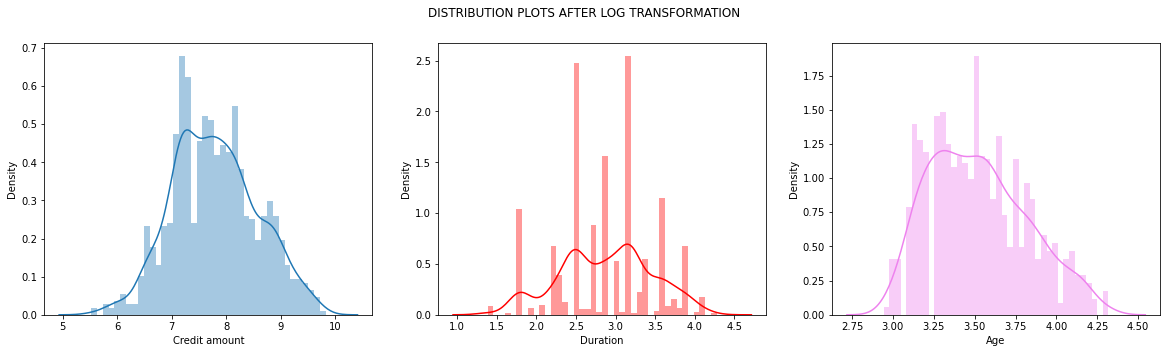

In [14]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRIBUTION PLOTS AFTER LOG TRANSFORMATION')
sns.distplot(trans_cols['Credit amount'], bins=40, ax=ax[0])
sns.distplot(trans_cols['Duration'], bins=40, ax=ax[1], color='red')
sns.distplot(trans_cols['Age'], bins=40, ax=ax[2], color='violet')

> The numerical variables look normalised now.

### Filling in the missing values
As the main focus of this project is to classify a customer to be good/bad, and deposit in accounts can be a major role in deciding that. So, the substitutions for the missing values will be filled with 'unknown' instead of one of the exisiting categories to eliminate any type of bias that may arise while doing classification.

In [15]:
data["Saving accounts"].fillna('unavailable', inplace = True)
data["Checking account"].fillna('unavailable', inplace = True)

In [16]:
data.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

# Feature Scaling
> Adding the 'job' column to the transformed numerical variables and performing Standard Scaling to the data columns.

In [17]:
trans_cols['Job'] = data['Job'].values
trans_cols.head()

,Credit amount,Duration,Age,Job
0,7.063904,1.791759,4.204693,2
1,8.691315,3.871201,3.091042,2
2,7.647786,2.484907,3.891820,1
3,8.972337,3.737670,3.806662,2
4,8.490849,3.178054,3.970292,2


In [18]:
sc = StandardScaler()
std_scaled_features = sc.fit_transform(trans_cols)
scaled_numerical_df = pd.DataFrame(std_scaled_features, columns = trans_cols.columns)
scaled_numerical_df.head()

,Credit amount,Duration,Age,Job
0,-0.933901,-1.864869,2.271006,0.146949
1,1.163046,1.708369,-1.446152,0.146949
2,-0.181559,-0.673790,1.226696,-1.383771
3,1.525148,1.478913,0.942455,0.146949
4,0.904743,0.517289,1.488620,0.146949


# K-Means Clustering for K = 1  to  K = 16 using the Scaled Numerical Variables

In [19]:
def plot_elbow(var, name):
    plt.figure(figsize=(11, 7))
    plt.plot(range(1, 15), var, 'r*-')
    plt.title(f'Elbow Method using {name}')
    plt.xlabel('Number of clusters')
    plt.ylabel(f'{name}')
    plt.show()

In [20]:
distortions = []
inertias = []
K = range(2, 16)
for k in K:
    model = KMeans(n_clusters=k)
    model.fit(std_scaled_features)
    inertias.append(model.inertia_)
    distortions.append(sum(np.min(cdist(std_scaled_features, model.cluster_centers_,
                                        'euclidean'), axis=1)) / std_scaled_features.shape[0])
    

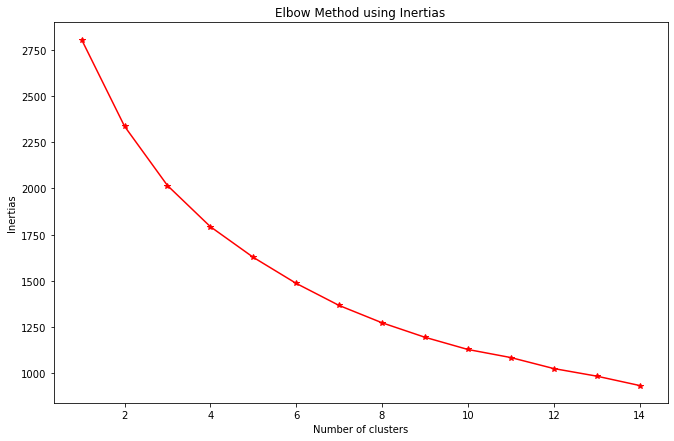

In [21]:
plot_elbow(inertias, "Inertias")

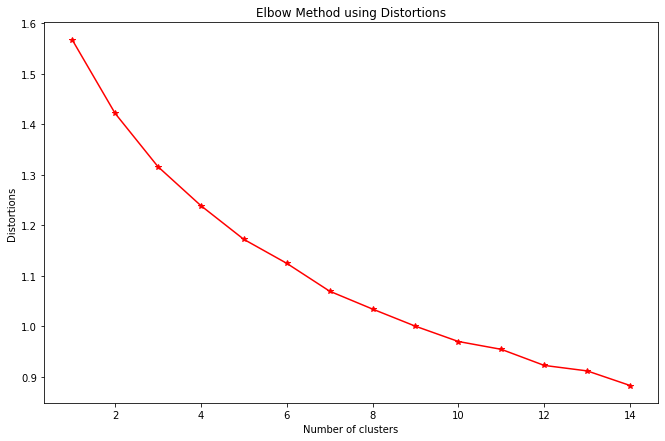

In [22]:
plot_elbow(distortions, "Distortions")

###  Observation:  
> As from both distortions and inertia graphs, we can see that the optimal number of clusters are around **3 and 4**, with **3** being more prominent number due to a linear behaviour of our graph after that point.

### KMeans clustering the 3 number of clusters

In [23]:
km = KMeans(n_clusters=3)
km.fit(std_scaled_features)
km.inertia_

2336.4673626639706

In [24]:
a = pd.Series(km.labels_).sort_values(ascending=True)
a.value_counts().sort_index()

0    241
1    385
2    374
dtype: int64

> The data points are assigned into 3 clusters with clusters 1 and 2 having almost equal number of datapoints.

# Principal Component Analysis

In [25]:
# Helper Functions

def pca_metrics(pca, components):
    with np.printoptions(precision=3):
        print(f"With components = {components}")
        print("Explained Variance: {}\nExplained Variance Ratio: {}\nExplained Variance Ratio sum: {}".format(pca.explained_variance_,
                                                                                                             pca.explained_variance_ratio_,
                                                                                                             round(pca.explained_variance_ratio_.sum(),3)))
    

def plot_pca_clusters(pca_trans, comp1, comp2, comp1_label, comp2_label):
    plt.figure(figsize = (8,8))
    sns.set()
    sns.scatterplot(pca_trans[:,comp1], pca_trans[:,comp2],
                    hue=km.labels_, 
                    palette="gist_rainbow",
                    s=50, alpha=0.6).set_title('7 Clusters', fontsize=15)
    plt.legend()
    plt.ylabel(comp1_label)
    plt.xlabel(comp2_label)
    plt.show()

### PCA with 2 Components

In [26]:
pca_2_comp = PCA(n_components=2)
pca_2_trans = pca_2_comp.fit_transform(std_scaled_features)
pca_metrics(pca_2_comp, 2)

With components = 2
Explained Variance: [1.798 1.013]
Explained Variance Ratio: [0.449 0.253]
Explained Variance Ratio sum: 0.702


> **Observation:**  
> The 1st principal explains around 45% percent of variance in our data and the 2nd principal around 25%. Collectively both the components explains 70% of variance.

In [27]:
pca_3_comp = PCA(n_components=3)
pca_3_trans = pca_3_comp.fit_transform(std_scaled_features)
pca_metrics(pca_3_comp, 3)

With components = 3
Explained Variance: [1.798 1.013 0.825]
Explained Variance Ratio: [0.449 0.253 0.206]
Explained Variance Ratio sum: 0.908


> With 3 components, explained variance is around 90%. We will proceed with 2 principal components instead of 3, to eliminate the chance of overfitting because of its high explained variance.

### Plotting the clusters with Two principal components

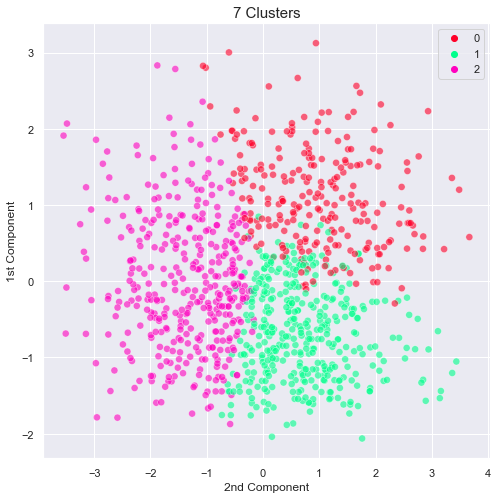

In [28]:
plot_pca_clusters(pca_2_trans, 0, 1, "1st Component", "2nd Component")

> We can see the 3 clusters using 2 principal components. The 3 clusters can be distinguished in 2 dimensional plane with distinct boundaries between clusters 1 and 2.

**Observing in 3 dimensional plane**

In [29]:
clusters = km.fit_predict(std_scaled_features)

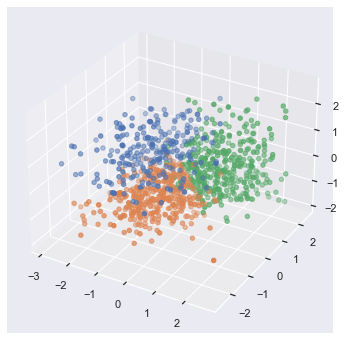

In [30]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    ax.scatter(std_scaled_features[clusters ==i,0], std_scaled_features[clusters ==i,1], std_scaled_features[clusters ==i,2])

# One hot encoding
One hot encoding the categorical variables.

### Label Encoding the target variable.

In [31]:
temp_data = data.copy()
temp_data = temp_data.replace({'Risk': {'good': 1, 'bad' : 0}})
target = temp_data['Risk']
features = temp_data.drop(['Risk'], axis = 1)

### Copying the Standard Scaled Numerical Features into the data set before performing One Hot Encoding. These Variables will be ignored by our encoder.

In [32]:
temp_data = features.copy()
for col in numerical_cols:
    temp_data[col] = scaled_numerical_df[col]

categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
encoded_cols = make_column_transformer((OneHotEncoder(), categorical_cols), remainder='passthrough')
final_data = encoded_cols.fit_transform(temp_data)

In [33]:
final_data.shape

(1000, 26)

> We can observe that our categorical variables are split into different columns by One Hot Encoder with increase in our columns from 9 to 26.

In [34]:
final_data = pd.DataFrame(final_data)
final_data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.271006,0.146949,-0.933901,-1.864869
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-1.446152,0.146949,1.163046,1.708369
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.226696,-1.383771,-0.181559,-0.673790
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.942455,0.146949,1.525148,1.478913
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.488620,0.146949,0.904743,0.517289


> The columns 0 - 21 are One Hot encoded Categorical Variables split and columns 22 - 25 are our scaled numerical variables.

# XGBoost Classification

In [35]:
## Helper Methods

def tune_hyperparameters(model, input_params, features, labels):
    cv = GridSearchCV(model, input_params, cv=5)
    cv.fit(features, labels)
    model_results(cv)
    
def model_results(results):
    print(f"Best Parameters: {results.best_params_}\n")
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, param in zip(means, stds, results.cv_results_['params']):
        print(f"{round(mean, 3)} (+/- {round(std*2, 3)}) for {param}")
        
def model_test_performance(model, training_set, test_set):
    model.fit(training_set['features'], training_set['labels']) # fitting on training set
    label_pred = model.predict(test_set['features']) # predicting on set other than training set
    label_true = test_set['labels']
    acc = round(accuracy_score(label_true, label_pred)*100, 2)
    prc = round(precision_score(label_true, label_pred, average='micro')*100, 2)
    rcl = round(recall_score(label_true, label_pred, average='micro')*100, 2)
    f1 = round(f1_score(label_true, label_pred)*100, 2)
    return({'acc': acc, 'prc': prc, 'rcl': rcl, 'f1': f1})

### Hypertuning the classifier for finding the 3 optimal parameters for our classifier

In [36]:
gb_parameters = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 1, None],
    'eval_metric': ['rmse', 'mlogloss']
}

tune_hyperparameters(model = XGBClassifier(), input_params = gb_parameters, features = final_data.values, labels= target)

Best Parameters: {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 50}

0.699 (+/- 0.056) for {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 10}
0.701 (+/- 0.053) for {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 50}
0.729 (+/- 0.033) for {'eval_metric': 'rmse', 'learning_rate': 0.01, 'n_estimators': 100}
0.722 (+/- 0.054) for {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 10}
0.746 (+/- 0.018) for {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 50}
0.743 (+/- 0.033) for {'eval_metric': 'rmse', 'learning_rate': 0.1, 'n_estimators': 100}
0.705 (+/- 0.041) for {'eval_metric': 'rmse', 'learning_rate': 1, 'n_estimators': 10}
0.722 (+/- 0.052) for {'eval_metric': 'rmse', 'learning_rate': 1, 'n_estimators': 50}
0.728 (+/- 0.06) for {'eval_metric': 'rmse', 'learning_rate': 1, 'n_estimators': 100}
0.736 (+/- 0.026) for {'eval_metric': 'rmse', 'learning_rate': None, 'n_estimators': 10}
0.737 (+/- 0.046) for {'eval_metric'

## Creating the classifier with optimal input parameters

In [37]:
xgb = XGBClassifier(learning_rate= 0.1, n_estimators= 50, eval_metric= 'rmse')
xgb

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='rmse',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method=None, validate_parameters=None,
              verbosity=None)

## 5 Fold Cross Validation and Performance Metric

In [38]:
cv = StratifiedKFold(n_splits=5)
metrics = ['accuracy', 'precision', 'recall', 'f1']
print("5 Fold Cross validation metrics for Extreme Gradient Boost Classifier:\n")
for m in metrics:
    score = cross_val_score(xgb, final_data.values, target, cv=cv, scoring=m)
    print(f"{m}: {round(score.mean()*100,2)}%")

5 Fold Cross validation metrics for Extreme Gradient Boost Classifier:

accuracy: 74.6%
precision: 78.35%
recall: 88.14%
f1: 82.93%


**Result:**  
> The model performed decently with about 75% accuracy. The f1 score is around 83% which means that our model is significant.